In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
from toy_plot_helpers import ToyPlot
plot = ToyPlot()

## Setting up the engine

We always need to set up an MD engine which knows the details of the system we're simulating. The MD engine always takes a template snapshot as an example of what the system looks like. Importantly, the template includes a `topology`, which contains information about how to calculate the interactions.

In [2]:
import openpathsampling.toy_dynamics as toys

pes = (
    toys.toy_pes.OuterWalls([1.0, 1.0], [0.0, 0.0]) + 
    toys.toy_pes.Gaussian(2.0, [1.0, 4.0], [0.0,1.0]) + 
    toys.toy_pes.Gaussian(2.0, [25.0, 1.0], [0.0, -1.0])
)

topology=paths.ToyTopology(
    n_spatial = 2,
    masses =[1.0, 1.0],
    pes = pes
)

template = paths.Snapshot(
    coordinates=np.array([[-0.5, 0.0]]), 
    velocities=np.array([[0.0,0.0]]),
    potential_energy = 0.0, # Important to set energies dimensionless otherwise kcal/mol is default
    kinetic_energy = 0.0,
    topology=topology
)

integ = toys.toy_integrators.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)

options={
    'integ' : integ,
    'n_frames_max' : 5000,
    'nsteps_per_frame' : 10
}

toy_eng = toys.toy_engine.ToyEngine(
    options=options,
    template=template
)
toy_eng.initialized = True

toy_eng.current_snapshot = template

Register this engine with the PathMovers

In [3]:
paths.SampleGeneratingMover.engine = toy_eng

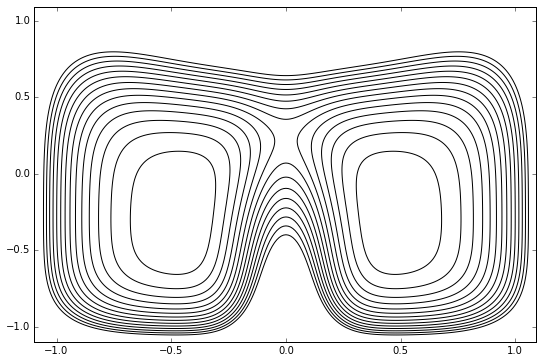

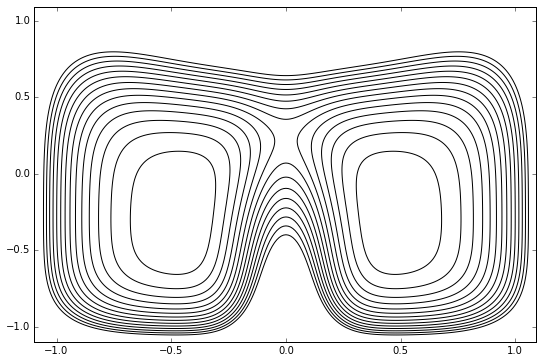

In [4]:
plot.add_pes(pes)
plot.plot()

## Loading trajectories from a previous calculation

Path sampling calculations take trajectories as input, so we need an input trajectory. We get that by running the `toy_bootstrap.ipynb`. Since that's a more advanced example, don't worry about understanding everything in there. Assuming you have an initial trajectory, all you need in order to run TIS is what's included in this notebook.


In [5]:
store_bootstrap = paths.storage.Storage('toy_bootstrap.nc', mode='r')

# note that the next three lines could be combined into one; they're separated here for educational purposes
final_sampleset = store_bootstrap.samplesets.last()
final_sample = final_sampleset.samples[-1]
traj = final_sample.trajectory

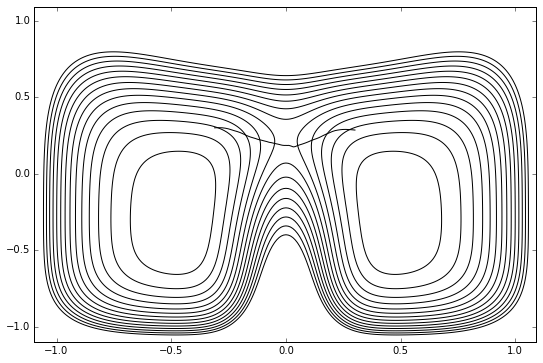

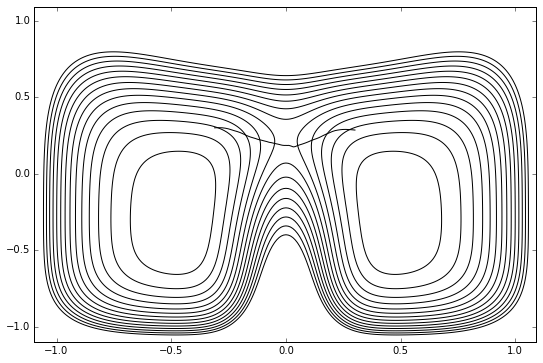

In [6]:
plot.plot([traj])

## Setting up order parameter, states, and interfaces

First we define the order parameter. We do this in two stages: first, we actually define a normal Python function which takes a `Snapshot` and return a number: in this case, the x-coordinate. Then we wrap that function into an OpenPathSampling order parameter using `paths.CV_Function`.

In [7]:
def xval(snapshot):
    """Return atom 0, coordinate 0 from the given snapshot"""
    return snapshot.xyz[0][0]
    

op_xval = paths.CV_Function(name="xval", fcn=xval)

Now we use that order parameter to define several volumes of interest. First we define the states. Note that we Python's `float("inf")` notation to create infinity (and negative infinity). The choice of where to set the state boundaries is based on the image or the PES above.

Then we set the interfaces using `CVRangeVolumeSet`.

In [8]:
stateA = paths.CVRangeVolume(op_xval, float("-inf"), -0.3)
stateB = paths.CVRangeVolume(op_xval, 0.3, float("inf"))

interfaces = paths.VolumeFactory.CVRangeVolumeSet(
    op_xval, 
    minvals=float("-inf"), 
    maxvals=[-0.30, -0.24, -0.18, -0.13, -0.08, -0.05]
)

## Equilibration in the path ensemble

At the end of the bootstrapping process, we have a set of paths which we can use to start TIS sampling. Before doing a production run, we should let these paths equilibrate within the ensembles. If you generate your initial path through dynamics that aren't the true dynamics (e.g., using high temperature runs or using metadynamics), this stage is **extremely** important. It's important here as well, but less so than if your initial path is non-physical.

First, we'll set up the `TISTransition` we're interested in. Since this particular calculation is just studying the A-to-B transition, we use this object. In general, you'll want to use one of the `TransitionNetwork` objects. See the `toy_network.ipynb` notebook for more information on studying networks of transitions.

In [9]:
tis_trans = paths.TISTransition(
    stateA=stateA,
    stateB=stateB,
    interfaces=interfaces,
    name="A->B equil",
    orderparameter=None # default order parameter for analysis; not used
)

In [10]:
initial_globalstate = paths.SampleSet.map_trajectory_to_ensembles(traj, tis_trans.ensembles)

In [11]:
initial_globalstate.sanity_check()

This will be an example of a "normal" TIS run, i.e., TIS without replica exchange. We will sampling using only shooter movers (the same ones defined for the bootstrapping) and path reversal movers.

In [12]:
store_equil = paths.storage.Storage("toy_equil.nc", "w", template=template)

equilibration = paths.PathSampling(
    storage=store_equil, 
    engine=toy_eng, 
    move_scheme=tis_trans.default_schemes(toy_eng),
    globalstate=initial_globalstate
)
equilibration.save_frequency=5

In [13]:
equilibration.globalstate.sanity_check()

In [14]:
while not stateA(equilibration.globalstate[0].trajectory[-1]): # keep equilibrating until innermost can extend to minus CLEAN THIS LATER
    equilibration.run(50)

DONE! Completed 150 Monte Carlo cycles.



## RETIS: Production run

Now we'll do a full production run using replica exchange TIS (RETIS).

First, we create a `RETISTransition`, in the same way that we created the `TISTransition`.

In [15]:
retis_trans = paths.RETISTransition(
    stateA=stateA,
    stateB=stateB,
    interfaces=interfaces,
    name="A->B",
    orderparameter=op_xval # we'll use this in the analysis notebook
)
start_gs = paths.SampleSet.translate_ensembles(equilibration.globalstate, retis_trans.ensembles)

At this point, we still don't have a path that satisfies the minus interface. 

In [16]:
#minus_segment = equilibration.globalstate[0].trajectory
#last_frame = minus_segment[-1]
#extension = toy_eng.generate(last_frame, [retis_trans.minus_ensemble.can_append])
#first_minus = paths.Trajectory(minus_segment + extension[1:])
#minus_samp = paths.Sample(
#    replica=-1,
#    trajectory=first_minus,
#    ensemble=retis_trans.minus_ensemble,
#)
minus_samp = retis_trans.minus_ensemble.populate_minus_ensemble(
    partial_traj=equilibration.globalstate[0].trajectory,
    minus_replica_id=-1,
    engine=toy_eng
)
start_gs = start_gs.apply_samples([minus_samp])

In [27]:
start_gs.sanity_check()

In [18]:
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [19]:
store_retis = paths.storage.Storage("_toy_retis.nc", "w", template=template)
store_retis.save(retis_trans)

True

In [20]:
production = paths.PathSampling(
    storage=store_retis,
    engine=toy_eng,
    move_scheme=retis_trans.default_schemes(toy_eng),
    globalstate=start_gs
)
production.save_frequency = 10

In [21]:
#stats = %prun -r 
production.run(1000)

DONE! Completed 1000 Monte Carlo cycles.



In [ ]:
#stats.dump_stats('output_200.pstats')

In [ ]:
#%load_ext line_profiler

In [ ]:
#%lprun  -f paths.SequentialEnsemble._find_subtraj_final \
#        -f paths.SequentialEnsemble._find_subtraj_first \
#        production.run(100)

In [26]:
c = store_retis.cvs[0]
c(minus_samp.trajectory)

[-0.31566727,
 -0.29759142,
 -0.28229746,
 -0.26735541,
 -0.25220045,
 -0.23855194,
 -0.22653967,
 -0.21646753,
 -0.20777275,
 -0.20033216,
 -0.19436073,
 -0.18825215,
 -0.1806218,
 -0.17143103,
 -0.16190234,
 -0.15277578,
 -0.1435598,
 -0.13449398,
 -0.12538664,
 -0.11542293,
 -0.10550137,
 -0.096268572,
 -0.08725486,
 -0.078916863,
 -0.071214586,
 -0.061602194,
 -0.073329657,
 -0.084279992,
 -0.093868434,
 -0.10179751,
 -0.10959878,
 -0.11915138,
 -0.12916479,
 -0.13890347,
 -0.15015459,
 -0.16210721,
 -0.17315303,
 -0.18399441,
 -0.19489758,
 -0.20651864,
 -0.21848838,
 -0.23005992,
 -0.24297374,
 -0.25699577,
 -0.27118129,
 -0.28681684,
 -0.30394793,
 -0.32136652,
 -0.33786514,
 -0.35411209,
 -0.37106952,
 -0.38738266,
 -0.40244311,
 -0.41694629,
 -0.43178183,
 -0.44808081,
 -0.46530762,
 -0.48191532,
 -0.49779674,
 -0.5152722,
 -0.53343493,
 -0.54826641,
 -0.56001318,
 -0.56957924,
 -0.57720608,
 -0.58356339,
 -0.59042341,
 -0.5966298,
 -0.59949607,
 -0.59986246,
 -0.59764534,
 -0

In [73]:
step = store_retis.steps[7]

In [74]:
print step.change

PathSimulatorStep : PathSampling : Step # 7 with 1 samples
 +- RandomChoice :
 |   +- RandomChoice :
 |   |   +- OneWayShooting :
 |   |   |   +- SampleMove : ForwardShootMover : True : 1 samples [<Sample @ 0x1159a5c10>]


In [79]:
res = step.change.subchange.subchange.subchange.subchange.trials[0]
print res.ensemble(res)
print res.idx
print res.trajectory.idx

True
{Storage @ '_toy_retis.nc': 14}
{Storage @ '_toy_retis.nc': 12}


In [76]:
res.ensemble(res)

True

In [78]:
res.idx

{Storage @ '_toy_retis.nc': 14}

In [50]:
print res.trajectory[0].coordinates

[[-0.30708721 -0.01264844]]


In [64]:
for s in store_retis.snapshots:
    if (xval(s) - 0.30752018)*(xval(s) - 0.30752018) < 0.0000001:
        print s.idx.values(), xval(s)

[2000] 0.30752
[2001] 0.30752
[4564] 0.307608
[4565] 0.307608
[4932] 0.307829
[4933] 0.307829
[8444] 0.307235
[8445] 0.307235
[19496] 0.307752
[19497] 0.307752
[20086] 0.307699
[20087] 0.307699
[30676] 0.30751
[30677] 0.30751


In [66]:
res.trajectory.idx

{Storage @ '_toy_retis.nc': 12}

In [67]:
res.trajectory.idx

{Storage @ '_toy_retis.nc': 12}

In [68]:
res.idx

{Storage @ '_toy_retis.nc': 14}

In [70]:
res.trajectory[10].coordinates

array([[-0.20327237,  0.03891134]], dtype=float32)